____
# Pac-Man AI ~ Research Notebook
____

## Important

1. All manually set hyperparamters must be configured manually in the optuna optimization step, as well as in the final training step
___

## 1. Dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import curses
import joblib

In [3]:
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

In [4]:
import optuna
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

In [5]:
from pacman_gymenv import PacmanEnvironment

## 2. General configuration

In [6]:
N_CPU = 8

## Hyperparamter Optimization with Optuna

In [38]:
# config
MAP                     = "pacman/maps/lv4.txt"
PACMAN_ENV              = PacmanEnvironment(pacmanmap=MAP)
POLICY_CONFIG           = {"layers": [64, 64]}

                        # lower-bound, upper-bound
TUNING_HORIZON          = [32,          5000            ]
TUNING_MINIBATCH_RANGE  = [4,           4096            ]
TUNING_EPOCHS           = [3,           30              ]
TUNING_CLIP_RANGE       = [0.1,         0.3             ]
TUNING_GAMMA            = [0.8,         0.9997          ]
TUNING_GAE              = [0.9,         1.0             ]
TUNING_VF               = [0.5,         1.0             ]
TUNING_EF               = [0.0,         0.01            ]
TUNING_LEARNINGRATE     = [5e-6,        0.003           ]

TUNING_STEPS            = 2
TUNING_TIMESTEPS        = 4096

lvname = MAP.replace('/','_').split('.', -1)[0]

In [39]:
# optuna objective function
def objective_ppo(trial):
        verbose         = 0
        seed            = 0
        # n_steps       = trial.suggest_int(    'n_steps',              TUNING_HORIZON[0],              TUNING_HORIZON[1])
        # batch_size    = trial.suggest_int(    'batch_size',           TUNING_MINIBATCH_RANGE[0],      TUNING_MINIBATCH_RANGE[1])
        n_epochs        = trial.suggest_int(    'n_epochs',             TUNING_EPOCHS[0],               TUNING_EPOCHS[1])
        clip_range      = trial.suggest_float(  'clip_range',           TUNING_CLIP_RANGE[0],           TUNING_CLIP_RANGE[1]);
        gamma           = trial.suggest_float(  'gamma',                TUNING_GAMMA[0],                TUNING_GAMMA[1])
        # gae_labmda    = trial.suggest_float(  'gae_lambda',           TUNING_GAE[0],                  TUNING_GAE[1])
        # vf_coef       = trial.suggest_float(  'vf_coef',              TUNING_VF[0],                   TUNING_VF[1])
        ent_coef        = trial.suggest_float(  'ent_coef',             TUNING_EF[0],                   TUNING_EF[1])
        learning_rate   = trial.suggest_float(  'learning_rate',        TUNING_LEARNINGRATE[0],         TUNING_LEARNINGRATE[1])

        env = SubprocVecEnv([lambda: Monitor(PACMAN_ENV) for i in range(N_CPU)])
        model = PPO(
                policy          = "MlpPolicy",
                env             = env,
                learning_rate   = learning_rate,
                n_steps         = 2048,
                batch_size      = 64,
                n_epochs        = n_epochs,
                gamma           = gamma,
                gae_lambda      = 0.95,
                clip_range      = clip_range,
                ent_coef        = ent_coef,
                vf_coef         = 0.5,
                verbose         = 0,
                seed            = 0,
                )
        model.learn(total_timesteps=TUNING_TIMESTEPS)

        reward_mean, _ = evaluate_policy(model, env)
        return reward_mean

In [40]:
# optimizeb
study = optuna.create_study(direction="maximize")
study.optimize(objective_ppo, n_trials=TUNING_STEPS, gc_after_trial=True)
studyname = f"{lvname}_{TUNING_STEPS}_{TUNING_TIMESTEPS}_{'_'.join([s.replace('_','') for s in study.best_params.keys()])}"

[I 2022-12-22 19:36:42,432] A new study created in memory with name: no-name-7e6d8f13-e7f7-4c27-828c-398cd574a633
[I 2022-12-22 19:37:37,250] Trial 0 finished with value: 44.0 and parameters: {'n_epochs': 16, 'clip_range': 0.10409530666750143, 'gamma': 0.8978586983604486, 'ent_coef': 0.003016460420849778, 'learning_rate': 0.0018499817532084033}. Best is trial 0 with value: 44.0.
[I 2022-12-22 19:38:41,734] Trial 1 finished with value: 20.0 and parameters: {'n_epochs': 19, 'clip_range': 0.24917654333762054, 'gamma': 0.9272746471645472, 'ent_coef': 0.0011965610681959839, 'learning_rate': 0.0028429762227636848}. Best is trial 0 with value: 44.0.


In [59]:
# save the study
joblib.dump(study, f"optuna_studies/{studyname}.pkl")

['optuna_studies/pacman_maps_lv4_2_4096_nepochs_cliprange_gamma_entcoef_learningrate.pkl']

In [60]:
study.best_params, study.best_value

({'n_epochs': 25,
  'clip_range': 0.26576821480457585,
  'gamma': 0.9215606092062559,
  'ent_coef': 0.008266010221544433,
  'learning_rate': 0.0007457636443173116},
 29.0)

In [61]:
fig = plot_optimization_history(study)
fig.show()
fig.write_image(f"images/{studyname}_optimization_hist.png")
fig.write_image(f"images/{studyname}_optimization_hist.eps")

In [62]:
fig = plot_param_importances(study)
fig.show()
fig.write_image(f"images/{studyname}_param_importances.png")
fig.write_image(f"images/{studyname}_param_importances.eps")


## Final Training

In [63]:
# config
MAP                     = "pacman/maps/lv4.txt"
PACMAN_ENV              = PacmanEnvironment(pacmanmap=MAP)
OPTUNA_STUDY_PATH       = "optuna_studies/pacman_maps_lv4_2_4096_nepochs_cliprange_gamma_entcoef_learningrate.pkl"
MODEL_TIMESTEPS         = 4096

optuna_study            = joblib.load(OPTUNA_STUDY_PATH)
lvname                  = MAP.replace('/','_').split('.', -1)[0]

In [64]:
# train
env = SubprocVecEnv([lambda: Monitor(PACMAN_ENV) for i in range(N_CPU)])
model = PPO(
    policy          = "MlpPolicy",
    env             = env,
    batch_size      = 64,
    n_steps         = 2048,
    gae_lambda      = 0.95,
    vf_coef         = 0.5,
    verbose         = 0,
    seed            = 0,
    **optuna_study.best_params
)
model.learn(MODEL_TIMESTEPS, progress_bar=True)

Output()

In [66]:
model.save(f"models/{lvname}_{MODEL_TIMESTEPS}_{OPTUNA_STUDY_PATH.replace('/','_').split('.', -1)[0]}")

## Analysis

In [7]:
MAP        = "pacman/maps/lv4.txt"
MODEL_PATH = "models/pacman_maps_lv4_4096_optuna_studies_pacman_maps_lv4_2_4096_nepochs_cliprange_gamma_entcoef_learningrate.zip"
PACMAN_ENV = PacmanEnvironment(pacmanmap=MAP)

modelname = MODEL_PATH.replace('/','_').split('.',-1)[0]
lvname = MAP.replace('/','_').split('.', -1)[0]
model  = PPO.load(MODEL_PATH)

In [9]:
# function to make plotting easier
def plot(path:str, title:str, xname:str, yname:str, ax) -> None:
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='silver')
    plt.subplots_adjust(bottom=0.15)
    plt.xlabel(xname) 
    plt.ylabel(yname)
    plt.title(title)
    plt.legend()
    plt.savefig(f"{path}.eps", format='eps')
    plt.savefig(f"{path}.png", format='png')
    plt.show()

In [10]:
data = []
pacmanenv = PACMAN_ENV
for i in range(512):
    finished = False
    framecnt = 0
    obs = pacmanenv.reset()
    while not finished:
        framecnt += 1
        action, _states = model.predict(obs)
        obs, rewards, finished, info = pacmanenv.step(action)
    data.append([1 if pacmanenv.game.pelletcount==0 else 0, pacmanenv.game.score, framecnt])

In [41]:
# only run this if you want to use data from a file instead of a model
data = np.genfromtxt(
    "saved_data/runlv3_2.txt", delimiter=", ", dtype=np.int16)
lvname = "pacman_maps_lv3.txt"
modelname = "lv3_2"

In [42]:
import os

folder = f"./analysis/{modelname}" 
if not os.path.exists(folder):
    os.mkdir(folder)
folder

'./analysis/lv3_2'

In [43]:
data = np.array(data)
data[:8], "...", data[-8:]

(array([[  1, 440,  51],
        [  1, 440,  93],
        [  0, 420,  92],
        [  1, 440,  64],
        [  1, 440,  59],
        [  1, 440,  49],
        [  1, 440,  65],
        [  1, 440,  49]], dtype=int16),
 '...',
 array([[  1, 440,  52],
        [  1, 440,  89],
        [  1, 440,  55],
        [  1, 440,  54],
        [  1, 440,  49],
        [  1, 440,  52],
        [  1, 440,  49],
        [  1, 440,  49]], dtype=int16))

In [44]:
# calculate win percentage
w  = data[:,0]
wc = np.count_nonzero(w == 1)
wp = wc/len(w)
print(f"   win percentage: {wp:20}%")

   win percentage:                0.809%


In [45]:
# calculate score data
s     = data[:,1]
s_mn  = np.mean(s)
s_std = np.std(s)
s_med = np.median(s)
print(f"  score mean:      {s_mn:20}")
print(f"  score std:       {s_std:20.2f}")
print(f"  score median:    {s_med:20}")

  score mean:                    425.65
  score std:                      43.21
  score median:                   440.0


In [46]:
# calculate time data (counted in steps taken)
t     = data[:,2]
t_mn  = np.mean(t)
t_std = np.std(t)
t_med = np.median(s)
print(f"  time mean:       {t_mn:20}")
print(f"  time std:        {t_std:20.2f}")
print(f"  time median:     {t_med:20}")

  time mean:                      61.06
  time std:                       18.79
  time median:                    440.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


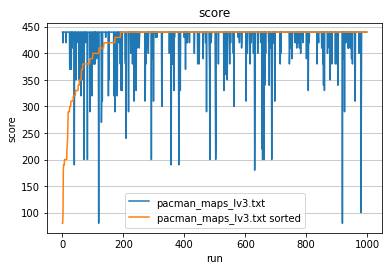

In [47]:
fig,ax = plt.subplots()
plt.plot(s, label=f"{lvname}")
plt.plot(np.sort(s), label=f"{lvname} sorted")
plot(f"{folder}/score", "score", "run", "score", ax)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


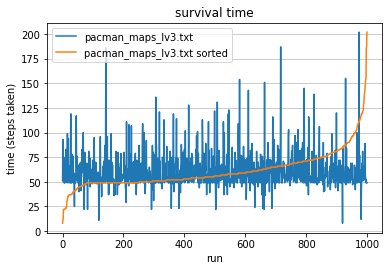

In [48]:
fig,ax = plt.subplots()
plt.plot(t, label=f"{lvname}")
plt.plot(np.sort(t), label=f"{lvname} sorted")
plot(f"{folder}/time", "survival time", "run", "time (steps taken)", ax)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


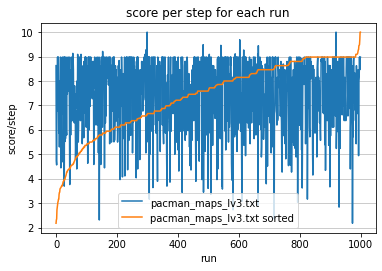

In [49]:
fig,ax = plt.subplots()
plt.plot(s/t, label=f"{lvname}")
plt.plot(np.sort(s/t), label=f"{lvname} sorted")
plot(f"{folder}/score_per_step", "score per step for each run", "run", "score/step", ax)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


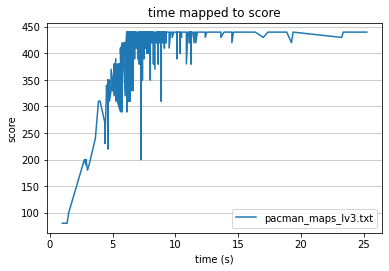

In [50]:
t_to_s = np.array(sorted(zip(t, s), key=lambda x:x[0]))

fig,ax = plt.subplots()
plt.plot(t_to_s[:,0]/8, t_to_s[:,1], label=f"{lvname}")
plot(f"{folder}/time_to_score", "time mapped to score", "time (s)", "score", ax)